In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/期末報告"
%ls

/content/drive/MyDrive/Colab Notebooks/期末報告
 emotion_model.h5
 emotion_model.json
'emotion_music_08_24 - 複製.ipynb'
'Example of Human Facial Expressions Emotions.mp4'
 haarcascade_frontalface_default.xml
 TrainEmotionDetector.ipynb


In [3]:
!pip install keras
!pip install tensorflow
!pip install pytube
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from pytube import Search
from pytube import YouTube
import os
from IPython.display import *


def music(emo):
  emotion_dict = {0: "mad", 1: "disgusted", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprised"}
  query = 'ncs ' + emotion_dict[emo] + ' music'
  s = Search(query)
  mus = ""
  for v in s.results:
    music_length=int(v.length)
    
    if music_length<300:
      print(f"{v.title}\n{v.watch_url}")
      music_list.append(v.title)
      length_list.append(v.length)

      target_path = "./downloads"
      yt = YouTube(v.watch_url)

      video = yt.streams.filter(only_audio=True).first()

      out_file = video.download(output_path=target_path)

      base, ext = os.path.splitext(out_file)
      new_file = base + '.mp3'
      mus = new_file
      
      os.rename(out_file, new_file)
      play_list.append(mus)
      break
  return mus

In [5]:
def play_sound(music):
  aud = Audio(music, autoplay=True)
  return aud

Loaded model from disk
1/1 [==============================] - 0s 22ms/step

大於三秒了,現在的情緒是: Fearful


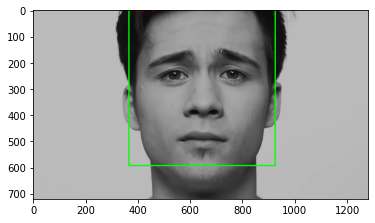

Lost Sky - Fearless pt.II (feat. Chris Linton) [NCS Release]
https://youtube.com/watch?v=S19UcWdOA-I


In [ ]:
import cv2
import time
import os
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow, show    
import numpy as np
import math
from keras.models import model_from_json
os.environ['CUDA_VISIBLE_DEVICES'] = "-1"
music_list = []
play_list = []
length_list = []
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}


json_file = open('emotion_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)
emotion_model.load_weights("emotion_model.h5")
print("Loaded model from disk")
cap = cv2.VideoCapture("Example of Human Facial Expressions Emotions.mp4")
emotion_past=-1
emotion_past_over_3ec=-1
music_count=0
test_num=1
while True:
  
    ret, frame = cap.read()
    frame = cv2.resize(frame, (1280, 720))
    if not ret:
        break
    face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    num_faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)
    if len(num_faces)==0:
      continue
    else:
      for (x, y, w, h) in num_faces:
          cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4)
          roi_gray_frame = gray_frame[y:y + h, x:x + w]
          cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)

          emotion_prediction = emotion_model.predict(cropped_img)
          emotion_now = int(np.argmax(emotion_prediction))
          cv2.putText(frame, emotion_dict[emotion_now], (x+5, y-20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
          
          

      if emotion_past != emotion_now:
        start=time.time()
        emotion_past=emotion_now

      music_start=time.time()
      if emotion_past==emotion_now:
        end=time.time()
        if end-start>3 and emotion_past_over_3ec!=emotion_now:
          print("\n大於三秒了,現在的情緒是:",emotion_dict[emotion_now])
          plt.pause(0.0001)
          plt.imshow(frame)
          show()
          play_music = music(emotion_now)
          music_start=time.time()
          wn = play_sound(play_list[music_count])
          display(wn)
          
          while True:
            music_end=time.time()
            if int(math.floor(music_end-music_start))==length_list[music_count]:
              music_count+=1
              print("上首歌:"+str(music_end-music_start)+"秒")
              break

          emotion_past_over_3ec=emotion_past


      if cv2.waitKey(1) & 0xFF == ord('q'):
          break

cap.release()
cv2.destroyAllWindows()